# Unsupervised clinical phenotyping + survival validation (no leakage)

This notebook uses **only** the preprocessed dataframe `df` loaded from `Dades/dt_model.csv` (expected: 147×26).

Main goal (Option A):
- Discover **unsupervised** phenotypes (clusters) **without** using the outcome.
- Profile clusters clinically.
- Validate if clusters separate prognosis (Kaplan–Meier + log-rank).
- Provide reproducible survival benchmarks (penalized Cox; RSF only if available).

Critical anti-leakage rule:
- `event` and `time_days` are **never** used as features for clustering nor for the "cluster explainer" tree.
- `event` and `time_days` are used **only** for survival validation and survival benchmarks.


In [1]:
# Core imports
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stats / clustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from scipy import stats

# ML utilities
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(RANDOM_STATE)

DATA_PATH = Path("Dades/dt_model.csv")
OUTPUT_DIR = Path("cluster")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.grid": True,
    "grid.alpha": 0.25,
})


In [2]:
# 0) Load preprocessed data (no data fabrication)

TARGET_EVENT = "event"
TARGET_TIME = "time_days"

# Expected schema (as provided)
num_cols = [
    "imc",
    "valor_de_ca125",
    "tamano_tumoral",
    "recep_est_porcent",
    "rece_de_Ppor",
    "edad_en_cirugia",
]

cat_cols = [
    "asa",
    "histo_defin",
    "grado_histologi",
    "FIGO2023",
    "afectacion_linf",
    "metasta_distan",
    "AP_centinela_pelvico",
    "AP_ganPelv",
    "AP_glanPaor",
    "beta_cateninap",
]

from_pre_cols = [
    "histo_defin__from_pre",
    "grado_histologi__from_pre",
    "FIGO2023__from_pre",
]

miss_cols = [
    "imc_miss",
    "tamano_tumoral_miss",
    "valor_de_ca125_miss",
]

flag_cols = from_pre_cols + miss_cols

df = pd.read_csv(DATA_PATH)
df = df.drop(columns=["recep_est_porcent_miss", "rece_de_Ppor_miss",])

# If an index column was persisted, restore it (optional)
if "Unnamed: 0" in df.columns and df["Unnamed: 0"].is_unique:
    df = df.set_index("Unnamed: 0")

def _clean_cat_value(x):
    """Normalize category-like values (e.g., '2.0' -> '2') without creating NaNs."""
    if pd.isna(x):
        return x
    s = str(x)
    if s.endswith(".0"):
        head = s[:-2]
        if head.replace("-", "").isdigit():
            return head
    return s

def clean_as_category(s: pd.Series) -> pd.Series:
    return s.map(_clean_cat_value).astype("category")

# Enforce dtypes as specified
for col in num_cols:
    df[col] = df[col].astype("float64")

for col in cat_cols:
    df[col] = clean_as_category(df[col])

for col in flag_cols:
    df[col] = df[col].astype("int8")

df[TARGET_EVENT] = df[TARGET_EVENT].astype("int64")
df[TARGET_TIME] = df[TARGET_TIME].astype("int64")


In [3]:
# 1) Initial audit (mandatory)

print("df.shape:", df.shape)
print("\n(df.dtypes)\n", df.dtypes)
print("\n(df.head)\n", df.head())

# Hard checks (raise on failure)
if df.isna().any().any():
    na_cols = df.columns[df.isna().any()].tolist()
    raise ValueError(f"NaNs detected in columns: {na_cols}")

event_values = set(df[TARGET_EVENT].unique().tolist())
if not event_values.issubset({0, 1}):
    raise ValueError(f"{TARGET_EVENT} must be binary {{0,1}}; got {sorted(event_values)}")

if (df[TARGET_TIME] < 0).any():
    raise ValueError(f"{TARGET_TIME} contains negative values")

for col in flag_cols:
    vals = set(df[col].unique().tolist())
    if not vals.issubset({0, 1}):
        raise ValueError(f"{col} must be binary 0/1; got {sorted(vals)}")

# Reports
print("\nEvent rate (mean event):", float(df[TARGET_EVENT].mean()))
print(
    "Time_days summary (min/median/max):",
    int(df[TARGET_TIME].min()),
    float(df[TARGET_TIME].median()),
    int(df[TARGET_TIME].max()),
)

print("\nCategorical levels per column:")
for col in cat_cols:
    vc = df[col].value_counts(dropna=False)
    print(f"\n- {col} (n_levels={vc.shape[0]}):")
    print(vc)

feature_cols = [c for c in df.columns if c not in [TARGET_EVENT, TARGET_TIME]]

expected_feature_set = set(num_cols + cat_cols + flag_cols)
actual_feature_set = set(feature_cols)
if actual_feature_set != expected_feature_set:
    missing = sorted(expected_feature_set - actual_feature_set)
    extra = sorted(actual_feature_set - expected_feature_set)
    raise ValueError(
        "feature_cols mismatch vs expected schema. "
        f"Missing: {missing}; Extra: {extra}"
    )

print("\nTARGET_EVENT:", TARGET_EVENT)
print("TARGET_TIME:", TARGET_TIME)
print("\nnum_cols:", num_cols)
print("\ncat_cols:", cat_cols)
print("\nflag_cols:", flag_cols)
print("\nfeature_cols (no leakage):", feature_cols)


df.shape: (147, 24)

(df.dtypes)
 imc                           float64
asa                          category
valor_de_ca125                float64
histo_defin                  category
grado_histologi              category
FIGO2023                     category
tamano_tumoral                float64
afectacion_linf              category
metasta_distan               category
AP_centinela_pelvico         category
AP_ganPelv                   category
AP_glanPaor                  category
recep_est_porcent             float64
rece_de_Ppor                  float64
beta_cateninap               category
event                           int64
time_days                       int64
edad_en_cirugia               float64
histo_defin__from_pre            int8
grado_histologi__from_pre        int8
FIGO2023__from_pre               int8
imc_miss                         int8
tamano_tumoral_miss              int8
valor_de_ca125_miss              int8
dtype: object

(df.head)
     imc asa  valor_de_ca125 

## 2) CLUSTERING (core) with mixed data: Gower + hierarchical

We compute **Gower distance** on `feature_cols` only (no outcome). Then we run **hierarchical clustering** on the precomputed distance.

Linkage choice: we use **complete linkage** to reduce the chaining effect and avoid extremely tiny/singleton clusters that can appear with average linkage on mixed-data distances.


In [4]:
# 2.1) Gower distance matrix (NxN) using ONLY feature_cols

X_features = df[feature_cols].copy()

def gower_distance_matrix_manual(
    X: pd.DataFrame,
    num_cols: list[str],
    cat_cols: list[str],
    flag_cols: list[str],
) -> np.ndarray:
    """Manual Gower distance for mixed data.

    - Numeric: min-max normalize, then absolute distance
    - Categorical / flags: 0 if equal else 1
    - Final Gower: mean across variables
    """
    n = X.shape[0]
    p = len(num_cols) + len(cat_cols) + len(flag_cols)
    if p == 0:
        raise ValueError("No features provided for Gower distance")

    D = np.zeros((n, n), dtype=np.float64)

    # Numeric part
    if num_cols:
        num = X[num_cols].to_numpy(dtype=np.float64)
        mins = num.min(axis=0)
        maxs = num.max(axis=0)
        ranges = maxs - mins
        ranges[ranges == 0.0] = 1.0
        num_norm = (num - mins) / ranges
        for j in range(num_norm.shape[1]):
            col = num_norm[:, j]
            D += np.abs(col[:, None] - col[None, :])

    # Categorical + flags part
    for col in (cat_cols + flag_cols):
        codes = pd.Categorical(X[col]).codes
        D += (codes[:, None] != codes[None, :]).astype(np.float64)

    D /= float(p)
    np.fill_diagonal(D, 0.0)
    # Ensure symmetry
    D = (D + D.T) / 2.0
    return D

try:
    import gower  # type: ignore
    D = np.asarray(gower.gower_matrix(X_features), dtype=np.float64)
    gower_backend = "gower (package)"
except ImportError:
    D = gower_distance_matrix_manual(X_features, num_cols=num_cols, cat_cols=cat_cols, flag_cols=flag_cols)
    gower_backend = "manual"

print(f"Gower backend: {gower_backend}")
print("D shape:", D.shape)
print("D min/max:", float(D.min()), float(D.max()))


Gower backend: manual
D shape: (147, 147)
D min/max: 0.0 0.7354299656486071


   K  silhouette  min_cluster_size                     cluster_sizes  \
0  2    0.216044                52                    {1: 52, 2: 95}   
1  3    0.230969                 6              {1: 52, 2: 6, 3: 89}   
2  4    0.249306                 6        {1: 52, 2: 6, 3: 83, 4: 6}   
3  5    0.253878                 2  {1: 52, 2: 6, 3: 83, 4: 2, 5: 4}   

   ARI_mean   ARI_std  
0  0.257527  0.327415  
1  0.331331  0.225657  
2  0.482691  0.190828  
3  0.535491  0.176172  


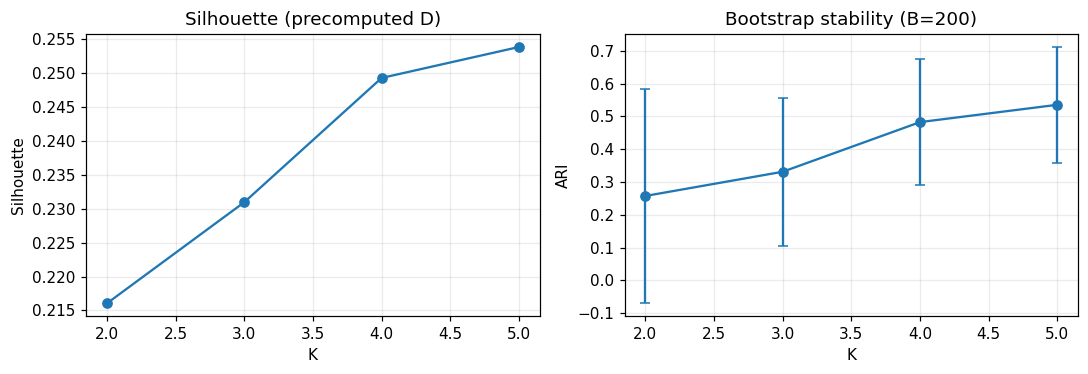

In [5]:
# 2.2) Choose K (2..5) using stability + silhouette (mandatory)

LINKAGE_METHOD = "complete"
B_BOOTSTRAP = 200

Z = linkage(squareform(D, checks=False), method=LINKAGE_METHOD)

def _safe_silhouette(D: np.ndarray, labels: np.ndarray) -> float:
    try:
        return float(silhouette_score(D, labels, metric="precomputed"))
    except Exception:
        return float("nan")

def bootstrap_stability_ari(
    D: np.ndarray,
    labels_ref: np.ndarray,
    K: int,
    method: str,
    B: int,
    rng: np.random.Generator,
) -> tuple[float, float]:
    n = D.shape[0]
    aris = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        D_b = D[np.ix_(idx, idx)]
        Z_b = linkage(squareform(D_b, checks=False), method=method)
        labels_b = fcluster(Z_b, t=K, criterion="maxclust")
        aris.append(adjusted_rand_score(labels_ref[idx], labels_b))
    return float(np.mean(aris)), float(np.std(aris))

labels_by_k = {}
rows = []

for K in range(2, 6):
    labels_k = fcluster(Z, t=K, criterion="maxclust").astype(int)
    labels_by_k[K] = labels_k

    sizes = pd.Series(labels_k).value_counts().sort_index()
    silhouette_k = _safe_silhouette(D, labels_k)
    ari_mean, ari_std = bootstrap_stability_ari(D, labels_k, K, LINKAGE_METHOD, B_BOOTSTRAP, rng)

    rows.append(
        {
            "K": K,
            "silhouette": silhouette_k,
            "min_cluster_size": int(sizes.min()),
            "cluster_sizes": dict(sizes),
            "ARI_mean": ari_mean,
            "ARI_std": ari_std,
        }
    )

clustering_metrics = pd.DataFrame(rows).sort_values("K").reset_index(drop=True)
print(clustering_metrics)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0].plot(clustering_metrics["K"], clustering_metrics["silhouette"], marker="o")
ax[0].set_title("Silhouette (precomputed D)")
ax[0].set_xlabel("K")
ax[0].set_ylabel("Silhouette")

ax[1].errorbar(
    clustering_metrics["K"],
    clustering_metrics["ARI_mean"],
    yerr=clustering_metrics["ARI_std"],
    marker="o",
    capsize=3,
)
ax[1].set_title(f"Bootstrap stability (B={B_BOOTSTRAP})")
ax[1].set_xlabel("K")
ax[1].set_ylabel("ARI")

plt.tight_layout()
plt.show()


In [6]:
# 2.3) Final assignment

N = df.shape[0]
min_allowed = max(10, int(np.ceil(0.03 * N)))  # pragmatic "not tiny" threshold

candidates = clustering_metrics[clustering_metrics["min_cluster_size"] >= min_allowed].copy()
if candidates.empty:
    candidates = clustering_metrics.copy()

candidates = candidates.sort_values(["ARI_mean", "silhouette"], ascending=[False, False])
K_final = int(candidates.iloc[0]["K"])

print(f"Selected K_final={K_final} (min_cluster_size threshold={min_allowed}).")
print("\nSelection table:")
print(clustering_metrics)

df_clusters = df.copy()
df_clusters["cluster"] = labels_by_k[K_final].astype(int)

print("\nCluster counts:")
print(df_clusters["cluster"].value_counts().sort_index())


Selected K_final=2 (min_cluster_size threshold=10).

Selection table:
   K  silhouette  min_cluster_size                     cluster_sizes  \
0  2    0.216044                52                    {1: 52, 2: 95}   
1  3    0.230969                 6              {1: 52, 2: 6, 3: 89}   
2  4    0.249306                 6        {1: 52, 2: 6, 3: 83, 4: 6}   
3  5    0.253878                 2  {1: 52, 2: 6, 3: 83, 4: 2, 5: 4}   

   ARI_mean   ARI_std  
0  0.257527  0.327415  
1  0.331331  0.225657  
2  0.482691  0.190828  
3  0.535491  0.176172  

Cluster counts:
cluster
1    52
2    95
Name: count, dtype: int64


## 3) Clinical cluster profiling (mandatory)

For each cluster:
- Numeric variables: median (IQR) + mean (SD)
- Categorical variables: within-cluster % by category (top levels)
- Flags/missing indicators: % of 1s

We also compute "most differential" variables across clusters:
- Numeric: Kruskal–Wallis (+ epsilon-squared effect size)
- Categorical/flags: Chi² (or Fisher exact when 2×2 and expected counts are low) + Cramer's V


In [7]:
CLUSTER_COL = "cluster"

def _fmt_median_iqr(x: pd.Series) -> str:
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    return f"{x.median():.2f} [{q1:.2f}, {q3:.2f}]"

def _fmt_mean_sd(x: pd.Series) -> str:
    return f"{x.mean():.2f} ({x.std(ddof=1):.2f})"

def summarize_numeric(df_in: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for cl, sub in df_in.groupby(CLUSTER_COL):
        for col in num_cols:
            rows.append(
                {
                    "cluster": int(cl),
                    "variable": col,
                    "type": "numeric",
                    "median_IQR": _fmt_median_iqr(sub[col]),
                    "mean_SD": _fmt_mean_sd(sub[col]),
                    "summary": f"median[IQR]={_fmt_median_iqr(sub[col])}; mean(SD)={_fmt_mean_sd(sub[col])}",
                }
            )
    return pd.DataFrame(rows)

def summarize_categorical(df_in: pd.DataFrame, top_n: int = 5) -> pd.DataFrame:
    rows = []
    for cl, sub in df_in.groupby(CLUSTER_COL):
        n = sub.shape[0]
        for col in cat_cols:
            vc = sub[col].value_counts(dropna=False)
            pct = (vc / n * 100.0).round(1)
            items = [f"{idx}: {val}%" for idx, val in pct.iloc[:top_n].items()]
            rows.append(
                {
                    "cluster": int(cl),
                    "variable": col,
                    "type": "categorical",
                    "summary": ", ".join(items),
                }
            )
    return pd.DataFrame(rows)

def summarize_flags(df_in: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for cl, sub in df_in.groupby(CLUSTER_COL):
        for col in flag_cols:
            pct1 = float(sub[col].mean() * 100.0)
            rows.append(
                {
                    "cluster": int(cl),
                    "variable": col,
                    "type": "flag",
                    "summary": f"%1={pct1:.1f}%",
                }
            )
    return pd.DataFrame(rows)

profile_num = summarize_numeric(df_clusters)
profile_cat = summarize_categorical(df_clusters, top_n=5)
profile_flag = summarize_flags(df_clusters)

profile_long = pd.concat([profile_num, profile_cat, profile_flag], ignore_index=True)
profile_wide = profile_long.pivot_table(index="cluster", columns="variable", values="summary", aggfunc="first")

profile_wide.to_csv(OUTPUT_DIR / "perfil_clusters.csv", index=True)
print(f"Exported: {OUTPUT_DIR / 'perfil_clusters.csv'}")
print("\nProfile preview:")
print(profile_wide.head())

def epsilon_squared_from_kruskal(H: float, k: int, n: int) -> float:
    # Common effect size approximation for Kruskal–Wallis
    if n <= k:
        return float("nan")
    return max(0.0, float((H - k + 1) / (n - k)))

def cramers_v_from_chi2(chi2: float, n: int, r: int, c: int) -> float:
    denom = n * (min(r - 1, c - 1))
    if denom <= 0:
        return float("nan")
    return float(np.sqrt(chi2 / denom))

diff_rows = []
clusters_sorted = sorted(df_clusters[CLUSTER_COL].unique().tolist())

# Numeric: Kruskal–Wallis
for col in num_cols:
    groups = [df_clusters.loc[df_clusters[CLUSTER_COL] == cl, col] for cl in clusters_sorted]
    try:
        stat, p = stats.kruskal(*groups)
        eff = epsilon_squared_from_kruskal(float(stat), k=len(groups), n=df_clusters.shape[0])
    except Exception:
        stat, p, eff = float("nan"), float("nan"), float("nan")
    diff_rows.append(
        {
            "variable": col,
            "type": "numeric",
            "test": "kruskal",
            "stat": float(stat),
            "p_value": float(p),
            "effect_size": float(eff),
        }
    )

# Categorical + flags: Chi2 or Fisher (2x2 only)
for col in (cat_cols + flag_cols):
    ct = pd.crosstab(df_clusters[CLUSTER_COL], df_clusters[col])
    try:
        chi2, p_chi2, dof, expected = stats.chi2_contingency(ct, correction=False)
        expected_low = (expected < 5).any()
        test_used = "chi2"
        p_used = float(p_chi2)
        if expected_low and ct.shape == (2, 2):
            # Fisher exact is only defined for 2x2 in SciPy
            test_used = "fisher_exact"
            _, p_fisher = stats.fisher_exact(ct.values)
            p_used = float(p_fisher)
        eff = cramers_v_from_chi2(float(chi2), n=int(ct.values.sum()), r=ct.shape[0], c=ct.shape[1])
        stat_val = float(chi2)
    except Exception:
        test_used, p_used, eff, stat_val = "na", float("nan"), float("nan"), float("nan")

    diff_rows.append(
        {
            "variable": col,
            "type": "categorical" if col in cat_cols else "flag",
            "test": test_used,
            "stat": stat_val,
            "p_value": p_used,
            "effect_size": eff,
        }
    )

diff_df = pd.DataFrame(diff_rows).sort_values("p_value", ascending=True)
print("\nTop-5 most differential variables (by p-value):")
print(diff_df.head(5))

# Short human-readable cluster profiles (non-causal language)
overall = df_clusters
cluster_text_profiles = {}

for cl, sub in df_clusters.groupby(CLUSTER_COL):
    candidates = []

    # Numeric deltas (median)
    for col in num_cols:
        delta = float(sub[col].median() - overall[col].median())
        candidates.append(
            (
                abs(delta),
                f"{col}: median {sub[col].median():.1f} vs global {overall[col].median():.1f} (Δ={delta:+.1f})",
            )
        )

    # Flags deltas (%1)
    for col in flag_cols:
        delta = float(sub[col].mean() - overall[col].mean())
        candidates.append(
            (
                abs(delta),
                f"{col}: %1 {sub[col].mean()*100:.1f}% vs global {overall[col].mean()*100:.1f}% (Δ={delta*100:+.1f}pp)",
            )
        )

    # Categorical deltas (top category)
    for col in cat_cols:
        top_level = sub[col].value_counts(dropna=False).index[0]
        p_cl = float((sub[col] == top_level).mean())
        p_gl = float((overall[col] == top_level).mean())
        delta = p_cl - p_gl
        candidates.append(
            (
                abs(delta),
                f"{col}='{top_level}': {p_cl*100:.1f}% vs global {p_gl*100:.1f}% (Δ={delta*100:+.1f}pp)",
            )
        )

    candidates.sort(key=lambda x: x[0], reverse=True)
    highlights = [txt for _, txt in candidates[:3]]
    cluster_text_profiles[int(cl)] = f"Perfil cluster {int(cl)} (descriptivo, no causal): " + "; ".join(highlights)

print("\nCluster profiles (short text):")
for cl in sorted(cluster_text_profiles):
    print("-", cluster_text_profiles[cl])


Exported: cluster/perfil_clusters.csv

Profile preview:
variable                               AP_centinela_pelvico  \
cluster                                                       
1         4: 78.8%, 0: 13.5%, Missing: 3.8%, 1: 1.9%, 2:...   
2         4: 49.5%, 0: 31.6%, Missing: 17.9%, 3: 1.1%, 1...   

variable                                   AP_ganPelv  \
cluster                                                 
1         0: 65.4%, 3: 17.3%, Missing: 15.4%, 1: 1.9%   
2          Missing: 88.4%, 0: 10.5%, 3: 1.1%, 1: 0.0%   

variable                                        AP_glanPaor  \
cluster                                                       
1         0: 44.2%, Missing: 44.2%, 3: 9.6%, 1: 1.9%, 2:...   
2         Missing: 96.8%, 0: 1.1%, 2: 1.1%, 3: 1.1%, 1: ...   

variable                                          FIGO2023 FIGO2023__from_pre  \
cluster                                                                         
1         4: 26.9%, 11: 23.1%, 1: 15.4%, 7: 7.7

## 4) Prognostic validation of clusters (now we use outcome)

- Kaplan–Meier curves by cluster
- Global log-rank test (pairwise optional)
- Simple Cox models: cluster only; and adjusted (age + FIGO2023)


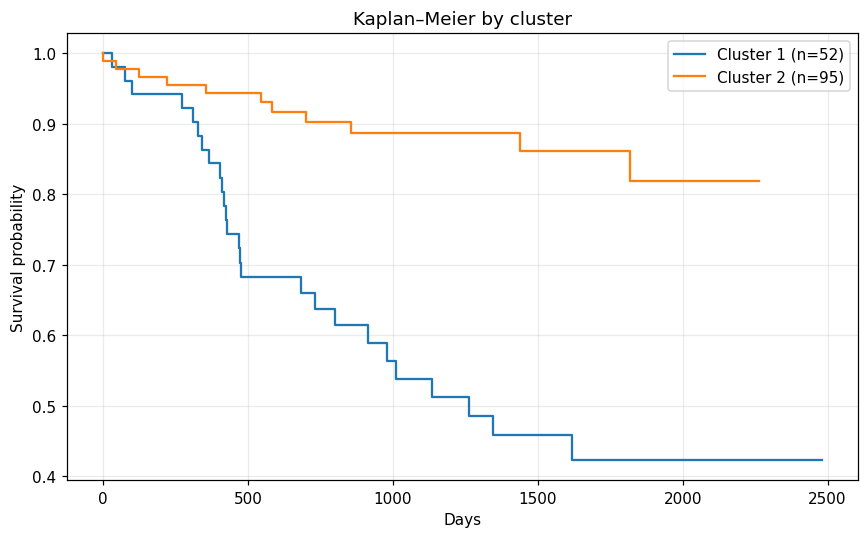

Global log-rank: chi2=22.958, dof=1, p=1.656e-06


In [8]:
# Kaplan–Meier + log-rank (implemented without external survival libraries)

def kaplan_meier_estimator(time: np.ndarray, event: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Returns step-wise KM survival curve (timeline, survival).

    This is a simple implementation (no CI) using the product-limit estimator.
    """
    time = np.asarray(time, dtype=float)
    event = np.asarray(event, dtype=int)

    unique_event_times = np.unique(time[event == 1])
    unique_event_times.sort()

    surv = 1.0
    timeline = [0.0]
    survival = [1.0]

    for t in unique_event_times:
        at_risk = np.sum(time >= t)
        if at_risk == 0:
            continue
        d = np.sum((time == t) & (event == 1))
        surv *= (1.0 - d / at_risk)
        timeline.append(float(t))
        survival.append(float(surv))

    # Extend to max time for nicer plotting
    tmax = float(np.max(time))
    if timeline[-1] < tmax:
        timeline.append(tmax)
        survival.append(float(surv))

    return np.asarray(timeline), np.asarray(survival)

def logrank_test_multigroup(time: np.ndarray, event: np.ndarray, group: np.ndarray) -> tuple[float, float, int]:
    """Multi-group log-rank test (Breslow) with chi-square approximation."""
    time = np.asarray(time, dtype=float)
    event = np.asarray(event, dtype=int)
    group = np.asarray(group)

    groups = np.unique(group)
    k = len(groups)
    if k < 2:
        return float("nan"), float("nan"), 0

    group_to_idx = {g: i for i, g in enumerate(groups)}
    g_idx = np.array([group_to_idx[g] for g in group], dtype=int)

    event_times = np.unique(time[event == 1])
    event_times.sort()

    O = np.zeros(k, dtype=float)
    E = np.zeros(k, dtype=float)
    V = np.zeros((k, k), dtype=float)

    for t in event_times:
        at_risk = time >= t
        n = int(at_risk.sum())
        if n <= 1:
            continue
        d = int(np.sum((time == t) & (event == 1)))
        if d == 0:
            continue

        n_g = np.zeros(k, dtype=float)
        d_g = np.zeros(k, dtype=float)
        for i in range(k):
            mask = g_idx == i
            n_g[i] = float(np.sum(at_risk & mask))
            d_g[i] = float(np.sum((time == t) & (event == 1) & mask))

        O += d_g
        E += d * (n_g / n)

        factor = d * (n - d) / (n - 1)
        if factor <= 0:
            continue
        p = n_g / n
        V += factor * (np.diag(p) - np.outer(p, p))

    U = O - E
    dof = k - 1
    # Reduce to k-1 dimensions to avoid singularity from the constraint sum(U)=0
    U_r = U[:-1]
    V_r = V[:-1, :-1]
    stat = float(U_r.T @ np.linalg.pinv(V_r) @ U_r)
    p_value = float(stats.chi2.sf(stat, dof))
    return stat, p_value, dof

time_all = df_clusters[TARGET_TIME].to_numpy()
event_all = df_clusters[TARGET_EVENT].to_numpy()
group_all = df_clusters[CLUSTER_COL].to_numpy()

# Plot KM
plt.figure(figsize=(8, 5))
for cl in sorted(df_clusters[CLUSTER_COL].unique().tolist()):
    sub = df_clusters[df_clusters[CLUSTER_COL] == cl]
    t, s = kaplan_meier_estimator(sub[TARGET_TIME].to_numpy(), sub[TARGET_EVENT].to_numpy())
    plt.step(t, s, where="post", label=f"Cluster {cl} (n={sub.shape[0]})")

plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier by cluster")
plt.legend()
plt.tight_layout()
plt.show()

# Global log-rank
lr_chi2, lr_p, lr_dof = logrank_test_multigroup(time_all, event_all, group_all)
logrank_global = {"chi2": lr_chi2, "p_value": lr_p, "dof": lr_dof}
print(f"Global log-rank: chi2={lr_chi2:.3f}, dof={lr_dof}, p={lr_p:.4g}")

# Pairwise log-rank (optional if K>2)
pairwise_logrank = None
clusters = sorted(df_clusters[CLUSTER_COL].unique().tolist())
if len(clusters) > 2:
    rows = []
    pairs = list(itertools.combinations(clusters, 2))
    m = len(pairs)
    for a, b in pairs:
        mask = df_clusters[CLUSTER_COL].isin([a, b]).to_numpy()
        chi2_ab, p_ab, dof_ab = logrank_test_multigroup(time_all[mask], event_all[mask], group_all[mask])
        rows.append(
            {
                "cluster_a": int(a),
                "cluster_b": int(b),
                "chi2": float(chi2_ab),
                "p_value": float(p_ab),
                "p_bonferroni": float(min(p_ab * m, 1.0)),
            }
        )
    pairwise_logrank = pd.DataFrame(rows).sort_values("p_value")
    print("\nPairwise log-rank (Bonferroni-corrected):")
    print(pairwise_logrank)


In [9]:
# Cox models (cluster only; and adjusted for age + FIGO2023)
# Implemented without external survival libraries.

def _cox_loglik_breslow(
    X_ord: np.ndarray,
    time_ord: np.ndarray,
    event_ord: np.ndarray,
    beta: np.ndarray,
    l2_penalty: float = 0.0,
) -> float:
    eta = X_ord @ beta
    shift = float(np.max(eta))
    w = np.exp(eta - shift)

    ll = 0.0
    cum_w = 0.0

    i = 0
    n = X_ord.shape[0]
    while i < n:
        t = time_ord[i]
        j = i
        while j < n and time_ord[j] == t:
            cum_w += float(w[j])
            j += 1

        d = int(np.sum(event_ord[i:j] == 1))
        if d > 0:
            ll += float(np.sum((X_ord[i:j] @ beta)[event_ord[i:j] == 1]))
            ll -= d * (shift + np.log(cum_w))
        i = j

    if l2_penalty > 0:
        ll -= 0.5 * l2_penalty * float(beta @ beta)
    return float(ll)

def _cox_grad_info_breslow(
    X_ord: np.ndarray,
    time_ord: np.ndarray,
    event_ord: np.ndarray,
    beta: np.ndarray,
    l2_penalty: float = 0.0,
) -> tuple[np.ndarray, np.ndarray]:
    eta = X_ord @ beta
    eta = eta - float(np.max(eta))  # safe shift
    w = np.exp(eta)

    p = X_ord.shape[1]
    grad = np.zeros(p, dtype=float)
    info = np.zeros((p, p), dtype=float)

    cum_w = 0.0
    cum_wx = np.zeros(p, dtype=float)
    cum_wxx = np.zeros((p, p), dtype=float)

    i = 0
    n = X_ord.shape[0]
    while i < n:
        t = time_ord[i]
        j = i

        # Add everyone with this time to the risk set (descending time => risk set is cumulative)
        while j < n and time_ord[j] == t:
            wi = float(w[j])
            xi = X_ord[j]
            cum_w += wi
            cum_wx += wi * xi
            cum_wxx += wi * np.outer(xi, xi)
            j += 1

        d = int(np.sum(event_ord[i:j] == 1))
        if d > 0:
            x_events = X_ord[i:j][event_ord[i:j] == 1].sum(axis=0)
            mean_x = cum_wx / cum_w
            grad += x_events - d * mean_x
            cov_x = cum_wxx / cum_w - np.outer(mean_x, mean_x)
            info += d * cov_x

        i = j

    if l2_penalty > 0:
        grad -= l2_penalty * beta
        info += l2_penalty * np.eye(p)

    return grad, info

def cox_ph_fit(
    X: np.ndarray,
    time: np.ndarray,
    event: np.ndarray,
    l2_penalty: float = 0.0,
    max_iter: int = 30,
    tol: float = 1e-6,
) -> tuple[np.ndarray, np.ndarray, float]:
    """Fits a (ridge-)penalized Cox PH model via Newton-Raphson.

    Returns (beta, cov(beta), loglik).
    """
    X = np.asarray(X, dtype=float)
    time = np.asarray(time, dtype=float)
    event = np.asarray(event, dtype=int)

    if X.ndim != 2:
        raise ValueError("X must be 2D")

    n, p = X.shape
    if n != time.shape[0] or n != event.shape[0]:
        raise ValueError("X/time/event length mismatch")

    order = np.argsort(-time)  # descending time
    X_ord = X[order]
    time_ord = time[order]
    event_ord = event[order]

    beta = np.zeros(p, dtype=float)
    ll = _cox_loglik_breslow(X_ord, time_ord, event_ord, beta, l2_penalty=l2_penalty)

    for _ in range(max_iter):
        grad, info = _cox_grad_info_breslow(X_ord, time_ord, event_ord, beta, l2_penalty=l2_penalty)
        delta = np.linalg.pinv(info) @ grad
        if float(np.max(np.abs(delta))) < tol:
            break

        # Simple backtracking line-search to stabilize updates
        step = 1.0
        accepted = False
        while step > 1e-4:
            beta_try = beta + step * delta
            ll_try = _cox_loglik_breslow(X_ord, time_ord, event_ord, beta_try, l2_penalty=l2_penalty)
            if ll_try >= ll - 1e-12:
                beta = beta_try
                ll = ll_try
                accepted = True
                break
            step *= 0.5

        if not accepted:
            # If line-search fails, still take the step (best-effort) and continue
            beta = beta + delta
            ll = _cox_loglik_breslow(X_ord, time_ord, event_ord, beta, l2_penalty=l2_penalty)

    # Final covariance from (penalized) observed information
    _, info = _cox_grad_info_breslow(X_ord, time_ord, event_ord, beta, l2_penalty=l2_penalty)
    cov = np.linalg.pinv(info)
    return beta, cov, float(ll)

def cox_summary(beta: np.ndarray, cov: np.ndarray, feature_names: list[str]) -> pd.DataFrame:
    se = np.sqrt(np.clip(np.diag(cov), 0.0, np.inf))
    z = np.divide(beta, se, out=np.full_like(beta, np.nan, dtype=float), where=se > 0)
    p = 2.0 * stats.norm.sf(np.abs(z))
    hr = np.exp(beta)
    ci_low = np.exp(beta - 1.96 * se)
    ci_high = np.exp(beta + 1.96 * se)
    return pd.DataFrame(
        {
            "feature": feature_names,
            "coef": beta,
            "se": se,
            "z": z,
            "p_value": p,
            "HR": hr,
            "HR_CI_low": ci_low,
            "HR_CI_high": ci_high,
        }
    ).sort_values("p_value")

# Cluster-only Cox (cluster as categorical via dummies)
X_cluster = pd.get_dummies(df_clusters[CLUSTER_COL].astype("category"), prefix="cluster", drop_first=True)
beta1, cov1, ll1 = cox_ph_fit(X_cluster.to_numpy(), time_all, event_all, l2_penalty=0.0)
cox_cluster_only = cox_summary(beta1, cov1, feature_names=list(X_cluster.columns))

print("Cox model: cluster only")
print(cox_cluster_only)

# Adjusted Cox: add age and FIGO2023 (dummies)
X_figo = pd.get_dummies(df_clusters["FIGO2023"].astype("category"), prefix="FIGO2023", drop_first=True)
X_adj = pd.concat([X_cluster, df_clusters[["edad_en_cirugia"]], X_figo], axis=1)

# Small ridge penalty for numerical stability (optional)
beta2, cov2, ll2 = cox_ph_fit(X_adj.to_numpy(), time_all, event_all, l2_penalty=1e-3)
cox_adjusted = cox_summary(beta2, cov2, feature_names=list(X_adj.columns))

print("\nCox model: cluster + age + FIGO2023 (adjusted)")
print(cox_adjusted)


Cox model: cluster only
     feature      coef        se         z   p_value        HR  HR_CI_low  \
0  cluster_2 -1.564145  0.360349 -4.340642  0.000014  0.209267   0.103268   

   HR_CI_high  
0    0.424068  

Cox model: cluster + age + FIGO2023 (adjusted)
             feature      coef         se         z   p_value        HR  \
0          cluster_2 -1.940696   0.586058 -3.311442  0.000928  0.143604   
2         FIGO2023_1 -1.826599   1.091011 -1.674226  0.094086  0.160960   
9         FIGO2023_4 -1.922304   1.236016 -1.555242  0.119888  0.146270   
7        FIGO2023_14  1.921469   1.245576  1.542634  0.122920  6.830986   
13        FIGO2023_9 -2.139553   1.525129 -1.402867  0.160656  0.117707   
3        FIGO2023_10 -1.956210   1.525049 -1.282719  0.199590  0.141393   
11        FIGO2023_7 -1.562714   1.529796 -1.021518  0.307009  0.209567   
14  FIGO2023_Missing  1.429888   1.442974  0.990931  0.321719  4.178229   
4        FIGO2023_11 -1.190021   1.204355 -0.988098  0.323104  0.3

## 5) Cluster "explainer" tree (recommended)

Goal: translate unsupervised clusters into simple, human-readable rules.

Important: the tree uses **only** `feature_cols` (no `event`, no `time_days`).


In [10]:
# Decision tree to predict cluster (interpretability tool)

tree_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("flags", "passthrough", flag_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=True,
)

tree_model = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
)

tree_pipe = Pipeline(
    steps=[
        ("preprocess", tree_preprocessor),
        ("tree", tree_model),
    ]
)

X_tree = df_clusters[feature_cols]
y_tree = df_clusters[CLUSTER_COL].astype(int)

cv_tree = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
acc = cross_val_score(tree_pipe, X_tree, y_tree, cv=cv_tree, scoring="accuracy")
print(f"Tree CV accuracy (5-fold): {acc.mean():.3f} ± {acc.std():.3f}")

tree_pipe.fit(X_tree, y_tree)

feature_names_tree = tree_pipe.named_steps["preprocess"].get_feature_names_out()
importances_tree = tree_pipe.named_steps["tree"].feature_importances_

imp_tree_df = pd.DataFrame(
    {"feature": feature_names_tree, "importance": importances_tree}
).sort_values("importance", ascending=False)

print("\nTop features (raw one-hot space):")
print(imp_tree_df.head(15))

cat_prefixes = sorted(cat_cols, key=len, reverse=True)
def _original_var_from_feature_name(feat: str) -> str:
    # feat comes like: 'num__imc', 'cat__FIGO2023_14', 'flags__imc_miss'
    if feat.startswith("num__"):
        return feat[len("num__"):]
    if feat.startswith("flags__"):
        return feat[len("flags__"):]
    if feat.startswith("cat__"):
        core = feat[len("cat__"):]
        for col in cat_prefixes:
            if core.startswith(col + "_"):
                return col
        return core
    return feat

imp_tree_df["original_variable"] = imp_tree_df["feature"].map(_original_var_from_feature_name)
imp_tree_var = (
    imp_tree_df.groupby("original_variable", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

print("\nTop variables (aggregated over one-hot):")
print(imp_tree_var.head(15))

rules_text = export_text(
    tree_pipe.named_steps["tree"],
    feature_names=list(feature_names_tree),
    decimals=2,
)
print("\nDecision tree rules (max_depth=3):\n")
print(rules_text)


Tree CV accuracy (5-fold): 0.939 ± 0.050

Top features (raw one-hot space):
                        feature  importance
49      cat__AP_ganPelv_Missing    0.598363
35       cat__afectacion_linf_1    0.195032
40  cat__AP_centinela_pelvico_0    0.114285
21              cat__FIGO2023_1    0.063821
5          num__edad_en_cirugia    0.014823
2           num__tamano_tumoral    0.013676
0                      num__imc    0.000000
4             num__rece_de_Ppor    0.000000
3        num__recep_est_porcent    0.000000
9              cat__asa_Missing    0.000000
10           cat__histo_defin_1    0.000000
11           cat__histo_defin_2    0.000000
12           cat__histo_defin_3    0.000000
13           cat__histo_defin_4    0.000000
6                    cat__asa_0    0.000000

Top variables (aggregated over one-hot):
            original_variable  importance
1                  AP_ganPelv    0.598363
5             afectacion_linf    0.195032
0        AP_centinela_pelvico    0.114285
3         

## 6) Survival benchmarks (reference only)

These models are **not** the main focus; they are included for a reproducible baseline.

- 6.1 Penalized Cox (preferred: scikit-survival Coxnet; fallback: ridge Cox implemented here)
- 6.2 Random Survival Forest (RSF) only if `scikit-survival` is available


In [11]:
# Benchmark utilities

def concordance_index(time: np.ndarray, score: np.ndarray, event: np.ndarray) -> float:
    """C-index for right-censored survival.

    This implementation assumes that higher `score` means higher risk (shorter survival).
    """
    time = np.asarray(time, dtype=float)
    score = np.asarray(score, dtype=float)
    event = np.asarray(event, dtype=int)

    n = time.shape[0]
    concordant = 0.0
    permissible = 0.0

    for i in range(n):
        for j in range(i + 1, n):
            ti, tj = time[i], time[j]
            ei, ej = event[i], event[j]
            si, sj = score[i], score[j]

            if ti == tj:
                continue

            if ti < tj:
                if ei != 1:
                    continue
                permissible += 1.0
                if si > sj:
                    concordant += 1.0
                elif si == sj:
                    concordant += 0.5
            else:
                if ej != 1:
                    continue
                permissible += 1.0
                if sj > si:
                    concordant += 1.0
                elif sj == si:
                    concordant += 0.5

    return float(concordant / permissible) if permissible > 0 else float("nan")

# Shared feature preprocessing for benchmarks (fit on train only inside CV)
bench_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("flags", "passthrough", flag_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=True,
)

X_bench_raw = df[feature_cols]
y_time = df[TARGET_TIME].to_numpy()
y_event = df[TARGET_EVENT].to_numpy()

cv_bench = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=RANDOM_STATE)
COX_L2_PENALTY = 1.0

cox_cindex_folds = []
for train_idx, test_idx in cv_bench.split(X_bench_raw, y_event):
    X_train = bench_preprocessor.fit_transform(X_bench_raw.iloc[train_idx])
    X_test = bench_preprocessor.transform(X_bench_raw.iloc[test_idx])

    beta, _, _ = cox_ph_fit(X_train, y_time[train_idx], y_event[train_idx], l2_penalty=COX_L2_PENALTY)
    risk = X_test @ beta
    c = concordance_index(y_time[test_idx], risk, y_event[test_idx])
    cox_cindex_folds.append(c)

cox_cindex_folds = np.asarray(cox_cindex_folds, dtype=float)
cox_cindex_mean = float(np.nanmean(cox_cindex_folds))
cox_cindex_std = float(np.nanstd(cox_cindex_folds))
print(f"Penalized Cox (ridge) C-index: {cox_cindex_mean:.3f} ± {cox_cindex_std:.3f}")

# Fit on full data for coefficients (interpretability)
X_all = bench_preprocessor.fit_transform(X_bench_raw)
beta_all, _, _ = cox_ph_fit(X_all, y_time, y_event, l2_penalty=COX_L2_PENALTY)
bench_feature_names = bench_preprocessor.get_feature_names_out()

coef_df = pd.DataFrame({"feature": bench_feature_names, "coef": beta_all})
coef_df["abs_coef"] = coef_df["coef"].abs()
print("\nTop 15 coefficients (one-hot space):")
print(coef_df.sort_values("abs_coef", ascending=False).head(15))

coef_df["original_variable"] = coef_df["feature"].map(_original_var_from_feature_name)
coef_by_var = (
    coef_df.groupby("original_variable", as_index=False)["abs_coef"]
    .sum()
    .sort_values("abs_coef", ascending=False)
)
print("\nTop 15 variables (sum abs(coef) over dummies):")
print(coef_by_var.head(15))

# RSF benchmark (only if scikit-survival is available)
rsf_results = None
try:
    from sksurv.ensemble import RandomSurvivalForest  # type: ignore
    from sksurv.util import Surv  # type: ignore
    from sksurv.metrics import concordance_index_censored  # type: ignore
    from sklearn.inspection import permutation_importance

    SKSURV_AVAILABLE = True
except ImportError:
    SKSURV_AVAILABLE = False
    print("\nscikit-survival not available: RSF benchmark is skipped (dependency missing).")

if SKSURV_AVAILABLE:
    y_struct = Surv.from_arrays(event=y_event.astype(bool), time=y_time.astype(float))

    # Fixed hyperparameters (from previous grid search)
    rsf_params = {
        "n_estimators": 600,
        "min_samples_split": 5,
        "min_samples_leaf": 5,
        "max_features": "sqrt",
    }

    def rsf_cindex(model, X_test, y_test):
        pred = model.predict(X_test)
        # concordance_index_censored expects higher score => higher risk
        return float(concordance_index_censored(y_test["event"], y_test["time"], pred)[0])

    fold_scores = []
    for train_idx, test_idx in cv_bench.split(X_bench_raw, y_event):
        X_train = bench_preprocessor.fit_transform(X_bench_raw.iloc[train_idx])
        X_test = bench_preprocessor.transform(X_bench_raw.iloc[test_idx])
        y_train = y_struct[train_idx]
        y_test = y_struct[test_idx]

        rsf = RandomSurvivalForest(random_state=RANDOM_STATE, n_jobs=-1, **rsf_params)
        rsf.fit(X_train, y_train)
        fold_scores.append(rsf_cindex(rsf, X_test, y_test))

    rsf_cindex_mean = float(np.mean(fold_scores))
    rsf_cindex_std = float(np.std(fold_scores))

    print("\nRSF best params:", rsf_params)
    print(f"RSF C-index: {rsf_cindex_mean:.3f} ± {rsf_cindex_std:.3f}")

    # Fit RSF on full data and compute permutation importance (risk score)
    X_all = bench_preprocessor.fit_transform(X_bench_raw)
    rsf_best = RandomSurvivalForest(random_state=RANDOM_STATE, n_jobs=-1, **rsf_params)
    rsf_best.fit(X_all, y_struct)

    def _rsf_scorer(estimator, X, y):
        pred = estimator.predict(X)
        return float(concordance_index_censored(y["event"], y["time"], pred)[0])

    perm = permutation_importance(
        rsf_best,
        X_all,
        y_struct,
        scoring=_rsf_scorer,
        n_repeats=30,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rsf_imp = pd.DataFrame(
        {"feature": bench_feature_names, "importance": perm.importances_mean}
    ).sort_values("importance", ascending=False)
    rsf_imp["original_variable"] = rsf_imp["feature"].map(_original_var_from_feature_name)
    rsf_imp_var = (
        rsf_imp.groupby("original_variable", as_index=False)["importance"]
        .sum()
        .sort_values("importance", ascending=False)
    )

    print("\nRSF permutation importance (top 15 variables):")
    print(rsf_imp_var.head(15))

    rsf_results = {
        "best_params": rsf_params,
        "cindex_mean": rsf_cindex_mean,
        "cindex_std": rsf_cindex_std,
        "perm_importance_by_variable": rsf_imp_var,
    }

# Export benchmark summary table
bench_rows = [
    {
        "model": "cox_ridge",
        "c_index_mean": cox_cindex_mean,
        "c_index_std": cox_cindex_std,
    }
]
if rsf_results is not None:
    bench_rows.append(
        {
            "model": "rsf",
            "c_index_mean": rsf_results["cindex_mean"],
            "c_index_std": rsf_results["cindex_std"],
        }
    )

benchmark_metrics = pd.DataFrame(bench_rows)
benchmark_metrics.to_csv(OUTPUT_DIR / "benchmark_survival_metrics.csv", index=False)
print(f"\nExported: {OUTPUT_DIR / 'benchmark_survival_metrics.csv'}")
print(benchmark_metrics)


Penalized Cox (ridge) C-index: 0.755 ± 0.074

Top 15 coefficients (one-hot space):
                             feature      coef  abs_coef
11                cat__histo_defin_2 -1.134257  1.134257
13                cat__histo_defin_4  1.097567  1.097567
14                cat__histo_defin_6  0.945526  0.945526
27                   cat__FIGO2023_2  0.772454  0.772454
54          cat__AP_glanPaor_Missing -0.757562  0.757562
60  flags__grado_histologi__from_pre  0.664285  0.664285
31                   cat__FIGO2023_8 -0.642354  0.642354
6                         cat__asa_0 -0.630456  0.630456
3             num__recep_est_porcent -0.629200  0.629200
29                   cat__FIGO2023_6  0.620013  0.620013
53                cat__AP_glanPaor_3  0.605006  0.605006
7                         cat__asa_1  0.597461  0.597461
12                cat__histo_defin_3 -0.594231  0.594231
41       cat__AP_centinela_pelvico_1  0.569297  0.569297
58       cat__beta_cateninap_Missing  0.533549  0.533549

Top 

## 7) Final outputs + `results` object (mandatory)

Exports:
- `cluster/df_con_clusters.csv` (original `df` + `cluster`)
- `cluster/perfil_clusters.csv`
- `cluster/benchmark_survival_metrics.csv`


In [12]:
# Export df with clusters (same index as df)
df_clusters.to_csv(OUTPUT_DIR / "df_con_clusters.csv", index=True)
print(f"Exported: {OUTPUT_DIR / 'df_con_clusters.csv'}")

# Collect all results in a single object
results = {
    "RANDOM_STATE": RANDOM_STATE,
    "K_final": K_final,
    "clustering": {
        "gower_backend": gower_backend,
        "linkage_method": LINKAGE_METHOD,
        "B_bootstrap": B_BOOTSTRAP,
        "distance_matrix_D": D,
        "metrics_by_K": clustering_metrics,
    },
    "df_clusters": df_clusters,
    "profiling": {
        "profile_long": profile_long,
        "profile_wide": profile_wide,
        "perfil_clusters_csv": str(OUTPUT_DIR / "perfil_clusters.csv"),
        "differential_variables": diff_df,
        "cluster_text_profiles": cluster_text_profiles,
    },
    "survival_validation": {
        "logrank_global": logrank_global,
        "logrank_pairwise": pairwise_logrank,
        "cox_cluster_only": cox_cluster_only,
        "cox_adjusted": cox_adjusted,
    },
    "cluster_explainer_tree": {
        "cv_accuracy_mean": float(acc.mean()),
        "cv_accuracy_std": float(acc.std()),
        "feature_importance_onehot": imp_tree_df,
        "feature_importance_by_variable": imp_tree_var,
        "rules_text": rules_text,
    },
    "benchmarks": {
        "cox_ridge": {
            "l2_penalty": COX_L2_PENALTY,
            "cindex_folds": cox_cindex_folds,
            "cindex_mean": cox_cindex_mean,
            "cindex_std": cox_cindex_std,
            "top_coefs_onehot": coef_df.sort_values("abs_coef", ascending=False).head(15),
            "top_vars_abscoef": coef_by_var.head(15),
        },
        "rsf": rsf_results,
        "benchmark_metrics": benchmark_metrics,
        "benchmark_metrics_csv": str(OUTPUT_DIR / "benchmark_survival_metrics.csv"),
    },
    "exports": {
        "df_con_clusters_csv": str(OUTPUT_DIR / "df_con_clusters.csv"),
        "perfil_clusters_csv": str(OUTPUT_DIR / "perfil_clusters.csv"),
        "benchmark_survival_metrics_csv": str(OUTPUT_DIR / "benchmark_survival_metrics.csv"),
    },
}

print("\nresults keys:", list(results.keys()))
print("Exports:")
for k, v in results["exports"].items():
    print(f"- {k}: {v}")


Exported: cluster/df_con_clusters.csv

results keys: ['RANDOM_STATE', 'K_final', 'clustering', 'df_clusters', 'profiling', 'survival_validation', 'cluster_explainer_tree', 'benchmarks', 'exports']
Exports:
- df_con_clusters_csv: cluster/df_con_clusters.csv
- perfil_clusters_csv: cluster/perfil_clusters.csv
- benchmark_survival_metrics_csv: cluster/benchmark_survival_metrics.csv


In [13]:
# 7) Export reproducible artifacts for an individual calculator
#
# Goal: save everything needed to reuse the models in a separate notebook
# without retraining (models + schema + training summary).

from pathlib import Path
import json

import joblib
import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

RANDOM_STATE = 42
HORIZONS_DAYS = [365, 1095, 1825]

ARTIFACT_DIR = Path('artifact')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
EVENT_COL = globals().get('TARGET_EVENT', 'event')
TIME_COL = globals().get('TARGET_TIME', 'time_days')
CLUSTER_COL = globals().get('CLUSTER_COL', 'cluster')

# Use df_clusters if available (it contains the target cluster labels).
if 'df_clusters' in globals():
    df_export = df_clusters.copy()
elif 'df' in globals() and CLUSTER_COL in df.columns:
    df_export = df.copy()
else:
    raise ValueError(
        'Expected `df_clusters` (or `df` with a `cluster` column) so we can train the cluster_assigner.'
    )

# Column lists should already exist earlier in this notebook (explicit schema).
for _name in ['num_cols', 'cat_cols', 'flag_cols']:
    if _name not in globals():
        raise ValueError(f'Missing `{_name}`. Define it earlier so the export schema is explicit.')

num_cols = list(num_cols)
cat_cols = list(cat_cols)
# Flags/missingness passthrough, excluding the two columns explicitly requested.
flag_cols = [c for c in list(flag_cols) if c not in {'recep_est_porcent_miss', 'rece_de_Ppor_miss'}]

FEATURE_COLS = num_cols + cat_cols + flag_cols

# Critical restriction: do not leak outcome/time/cluster into the cluster assigner.
leakage_cols = {EVENT_COL, TIME_COL, CLUSTER_COL}
leak_in_features = sorted(set(FEATURE_COLS) & leakage_cols)
if leak_in_features:
    raise ValueError(f'Leakage detected in FEATURE_COLS: {leak_in_features}')

missing_feature_cols = [c for c in FEATURE_COLS if c not in df_export.columns]
if missing_feature_cols:
    raise ValueError(f'Missing expected feature columns in df: {missing_feature_cols}')

# Shared preprocessing (same configuration for every exported model):
# - numeric: StandardScaler
# - categorical: OneHotEncoder(handle_unknown="ignore") for unseen categories
# - flags/miss: passthrough
#
# We create ONE template and `clone()` it when building pipelines to guarantee identical
# configuration without sharing fitted state across different models.
shared_preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('flags', 'passthrough', flag_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
)

# Export schema used by the calculator to validate inputs.
feature_schema = {
    'expected_columns': FEATURE_COLS,
    'num_cols': num_cols,
    'cat_cols': cat_cols,
    'flag_cols': flag_cols,
    'horizons_days': HORIZONS_DAYS,
}
with open(ARTIFACT_DIR / 'feature_schema.json', 'w', encoding='utf-8') as f:
    json.dump(feature_schema, f, indent=2, ensure_ascii=False)
print('Exported:', ARTIFACT_DIR / 'feature_schema.json')

# Training matrices / targets (X contains ONLY features; y_surv contains event+time).
X = df_export[FEATURE_COLS].copy()
y_surv = Surv.from_dataframe(EVENT_COL, TIME_COL, df_export)
y_cluster = df_export[CLUSTER_COL].astype(int).to_numpy()


Exported: artifact/feature_schema.json


In [14]:
# Train FINAL models on the FULL dataset and export artifacts

def _cindex_cv_5fold(pipeline: Pipeline, X_df: pd.DataFrame, y_struct) -> tuple[float, float]:
    """5-fold CV C-index for right-censored survival pipelines.

    Uses StratifiedKFold on the event indicator for more stable folds.
    Returns (mean, std) over folds.
    """
    event_indicator = y_struct['event'].astype(int)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores: list[float] = []

    for train_idx, test_idx in cv.split(X_df, event_indicator):
        est = clone(pipeline)
        est.fit(X_df.iloc[train_idx], y_struct[train_idx])
        risk = est.predict(X_df.iloc[test_idx])
        c = concordance_index_censored(
            y_struct[test_idx]['event'],
            y_struct[test_idx][TIME_COL],
            risk,
        )[0]
        scores.append(float(c))

    scores_arr = np.asarray(scores, dtype=float)
    return float(scores_arr.mean()), float(scores_arr.std(ddof=1))

# --- RSF (final fit on ALL data) ---
default_rsf_params = {
    'n_estimators': 600,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
}

# Prefer params found earlier in the notebook (if present); otherwise fall back to defaults.
rsf_best_params = dict(default_rsf_params)
if 'rsf_results' in globals() and isinstance(rsf_results, dict) and rsf_results.get('best_params'):
    rsf_best_params = dict(rsf_results['best_params'])
elif 'rsf_params' in globals() and isinstance(rsf_params, dict):
    rsf_best_params = dict(rsf_params)

risk_model_rsf = Pipeline(
    steps=[
        ('preprocess', clone(shared_preprocess)),
        ('model', RandomSurvivalForest(random_state=RANDOM_STATE, n_jobs=-1, **rsf_best_params)),
    ]
)

rsf_cindex_mean, rsf_cindex_std = _cindex_cv_5fold(risk_model_rsf, X, y_surv)
print(f'RSF 5-fold CV C-index: {rsf_cindex_mean:.3f} ± {rsf_cindex_std:.3f}')

risk_model_rsf.fit(X, y_surv)
joblib.dump(risk_model_rsf, ARTIFACT_DIR / 'risk_model_rsf.joblib')
print('Exported:', ARTIFACT_DIR / 'risk_model_rsf.joblib')

# --- Risk cutpoints (terciles) for production risk grouping (no patient CSV needed) ---
# We compute risk_3y = 1 - S(3y) over the RSF training set, then store only the
# 33% and 66% quantiles as artifact/risk_cutpoints.json (no patient-level data).

def _step_fn_value_at(step_fn, t_days: float) -> float:
    t = float(t_days)
    if hasattr(step_fn, 'x'):
        try:
            x = np.asarray(step_fn.x, dtype=float)
            if x.size > 0:
                t = min(t, float(x.max()))
        except Exception:
            pass

    try:
        return float(step_fn(t))
    except Exception:
        if hasattr(step_fn, 'x') and hasattr(step_fn, 'y'):
            x = np.asarray(step_fn.x, dtype=float)
            y = np.asarray(step_fn.y, dtype=float)
            if x.size == 0 or y.size == 0:
                return float('nan')
            idx = int(np.searchsorted(x, t, side='right') - 1)
            idx = max(0, min(idx, y.size - 1))
            return float(y[idx])
        raise

# Use the configured 3y horizon from the schema (defaults to 1095 days)
t3 = float(HORIZONS_DAYS[1]) if len(HORIZONS_DAYS) >= 2 else 1095.0

X_all_t = risk_model_rsf.named_steps['preprocess'].transform(X)
sf_all = risk_model_rsf.named_steps['model'].predict_survival_function(X_all_t)
S3 = np.asarray([_step_fn_value_at(sf, t3) for sf in sf_all], dtype=float)
risk_3y_all = 1.0 - S3

q33 = float(np.nanquantile(risk_3y_all, 1.0 / 3.0))
q66 = float(np.nanquantile(risk_3y_all, 2.0 / 3.0))

risk_cutpoints = {'q33': q33, 'q66': q66}
with open(ARTIFACT_DIR / 'risk_cutpoints.json', 'w', encoding='utf-8') as f:
    json.dump(risk_cutpoints, f, indent=2, ensure_ascii=False)
print('Exported:', ARTIFACT_DIR / 'risk_cutpoints.json')
print('Risk cutpoints (risk_3y terciles):', risk_cutpoints)

# --- Cox baseline (ridge-penalized) ---
COX_ALPHA = 1.0
risk_model_cox = Pipeline(
    steps=[
        ('preprocess', clone(shared_preprocess)),
        ('model', CoxPHSurvivalAnalysis(alpha=COX_ALPHA)),
    ]
)

cox_cindex_mean, cox_cindex_std = _cindex_cv_5fold(risk_model_cox, X, y_surv)
print(f'Cox (ridge, alpha={COX_ALPHA}) 5-fold CV C-index: {cox_cindex_mean:.3f} ± {cox_cindex_std:.3f}')

risk_model_cox.fit(X, y_surv)
joblib.dump(risk_model_cox, ARTIFACT_DIR / 'risk_model_cox.joblib')
print('Exported:', ARTIFACT_DIR / 'risk_model_cox.joblib')

# --- Cluster assigner (deterministic classifier for new patients) ---
cluster_assigner = Pipeline(
    steps=[
        ('preprocess', clone(shared_preprocess)),
        (
            'model',
            LogisticRegression(
                solver='lbfgs',
                multi_class='multinomial',
                max_iter=2000,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

cv_cluster = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
acc = cross_val_score(cluster_assigner, X, y_cluster, cv=cv_cluster, scoring='accuracy', n_jobs=-1)
print(f'Cluster assigner 5-fold CV accuracy: {acc.mean():.3f} ± {acc.std(ddof=1):.3f}')

cluster_assigner.fit(X, y_cluster)
y_pred = cluster_assigner.predict(X)
labels_sorted = sorted(np.unique(y_cluster).tolist())
cm = confusion_matrix(y_cluster, y_pred, labels=labels_sorted)
print()
print('Confusion matrix (train set):')
print(pd.DataFrame(cm, index=[f'true_{c}' for c in labels_sorted], columns=[f'pred_{c}' for c in labels_sorted]))

joblib.dump(cluster_assigner, ARTIFACT_DIR / 'cluster_assigner.joblib')
print('Exported:', ARTIFACT_DIR / 'cluster_assigner.joblib')

# --- Training summary JSON (for auditing) ---
cluster_sizes = df_export[CLUSTER_COL].value_counts().sort_index()
event_rate_global = float(df_export[EVENT_COL].mean())
event_rate_by_cluster = df_export.groupby(CLUSTER_COL)[EVENT_COL].mean().sort_index()

train_summary = {
    'rsf_cindex_cv_mean': rsf_cindex_mean,
    'rsf_cindex_cv_std': rsf_cindex_std,
    'cox_cindex_cv_mean': cox_cindex_mean,
    'cox_cindex_cv_std': cox_cindex_std,
    'cluster_sizes': {str(k): int(v) for k, v in cluster_sizes.items()},
    'event_rate_global': event_rate_global,
    'event_rate_by_cluster': {str(k): float(v) for k, v in event_rate_by_cluster.items()},
}

with open(ARTIFACT_DIR / 'train_summary.json', 'w', encoding='utf-8') as f:
    json.dump(train_summary, f, indent=2, ensure_ascii=False)
print('Exported:', ARTIFACT_DIR / 'train_summary.json')


RSF 5-fold CV C-index: 0.811 ± 0.037
Exported: artifact/risk_model_rsf.joblib
Exported: artifact/risk_cutpoints.json
Risk cutpoints (risk_3y terciles): {'q33': 0.10676842322737941, 'q66': 0.32160908694597884}
Cox (ridge, alpha=1.0) 5-fold CV C-index: 0.733 ± 0.057
Exported: artifact/risk_model_cox.joblib
Cluster assigner 5-fold CV accuracy: 0.938 ± 0.067

Confusion matrix (train set):
        pred_1  pred_2
true_1      51       1
true_2       0      95
Exported: artifact/cluster_assigner.joblib
Exported: artifact/train_summary.json


In [15]:
# Smoke test: run 3 real patients through the saved artifacts

with open(ARTIFACT_DIR / 'feature_schema.json', 'r', encoding='utf-8') as f:
    _schema = json.load(f)
expected_cols = _schema['expected_columns']
horizons = _schema['horizons_days']

cluster_assigner_loaded = joblib.load(ARTIFACT_DIR / 'cluster_assigner.joblib')
risk_model_rsf_loaded = joblib.load(ARTIFACT_DIR / 'risk_model_rsf.joblib')

df_smoke = df_export.sample(n=3, random_state=RANDOM_STATE)

def _safe_sf_at(step_fn, t_days: int) -> float:
    """Evaluate a scikit-survival StepFunction safely at a given horizon (days)."""
    t = float(t_days)
    if hasattr(step_fn, 'x') and len(step_fn.x) > 0:
        t = min(t, float(np.max(step_fn.x)))
    return float(step_fn(t))

print('\n--- Smoke test (3 real patients) ---')
for idx, row in df_smoke.iterrows():
    row_dict = row.to_dict()
    X_one = pd.DataFrame([row_dict])[expected_cols]

    cluster_pred = int(cluster_assigner_loaded.predict(X_one)[0])

    # Pipeline does not automatically wrap predict_survival_function(), so we call
    # it on the underlying model after applying the fitted preprocessor.
    X_one_t = risk_model_rsf_loaded.named_steps['preprocess'].transform(X_one)
    sf = risk_model_rsf_loaded.named_steps['model'].predict_survival_function(X_one_t)[0]

    s_1y = _safe_sf_at(sf, horizons[0])
    s_3y = _safe_sf_at(sf, horizons[1])
    s_5y = _safe_sf_at(sf, horizons[2])

    true_cluster = int(row[CLUSTER_COL]) if CLUSTER_COL in row_dict else None
    print(f'\nPatient index: {idx}')
    print(f'  true_cluster: {true_cluster} | cluster_pred: {cluster_pred}')
    print(f'  S(1y): {s_1y:.3f} | S(3y): {s_3y:.3f} | S(5y): {s_5y:.3f}')



--- Smoke test (3 real patients) ---

Patient index: 125
  true_cluster: 1 | cluster_pred: 1
  S(1y): 0.759 | S(3y): 0.363 | S(5y): 0.240

Patient index: 51
  true_cluster: 1 | cluster_pred: 1
  S(1y): 0.976 | S(3y): 0.888 | S(5y): 0.859

Patient index: 138
  true_cluster: 2 | cluster_pred: 2
  S(1y): 0.923 | S(3y): 0.847 | S(5y): 0.771
